In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
# Set up the directory path
directory = os.path.expanduser('~/Documents/Semester-5/DEEP-LEARNING/IMAGE_CAPTIONING/Flickr8K/Flicker8k_Images')

# Dictionary to store image features
features = {}

# Loop through images to extract features
for img_name in tqdm(os.listdir(directory)):
    try:
        # Load the image
        img_path = os.path.join(directory, img_name)
        image = load_img(img_path, target_size=(224, 224))
        
        # Convert the image to a numpy array
        image = img_to_array(image)
        
        # Expand dimensions to fit the model input shape
        image = np.expand_dims(image, axis=0)
        
        # Preprocess the image
        image = preprocess_input(image)
        
        # Extract features using VGG16
        feature = model.predict(image, verbose=0)
        
        # Get the image ID and store the feature
        image_id = img_name.split('.')[0]
        features[image_id] = feature
    except Exception as e:
        print(f"Error processing {img_name}: {e}")
        continue

# Save the features to a file for later use
with open('image_features.pkl', 'wb') as f:
    pickle.dump(features, f)

print("Feature extraction and saving complete.")

 40%|███████████████▍                       | 3210/8092 [10:05<13:59,  5.81it/s]

Error processing image_features.pkl: cannot identify image file <_io.BytesIO object at 0x163174540>


100%|███████████████████████████████████████| 8092/8092 [25:44<00:00,  5.24it/s]


Feature extraction and saving complete.


In [10]:
# Define the directory where you want to save the pickle file
working_dir = os.path.expanduser('~/Documents/Semester-5/DEEP-LEARNING/IMAGE_CAPTIONING')

# Save the features dictionary as a pickle file
pickle.dump(features, open(os.path.join(working_dir, 'features.pkl'), 'wb'))

print("Features have been saved to features.pkl.")

Features have been saved to features.pkl.


In [12]:
# Define the directory where your pickle file is saved
working_dir = os.path.expanduser('~/Documents/Semester-5/DEEP-LEARNING/IMAGE_CAPTIONING')

# Load the features dictionary from the pickle file
with open(os.path.join(working_dir, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

print("Features have been loaded from features.pkl.")


Features have been loaded from features.pkl.


In [14]:
import os

# Define the full path for your captions file
captions_path = os.path.expanduser('~/Documents/Semester-5/DEEP-LEARNING/IMAGE_CAPTIONING/Flickr8K/captions.txt')

# Open and read the captions file
with open(captions_path, 'r') as f:
    next(f)  # Skip the header line if present
    captions_doc = f.read()

print("Captions have been loaded.")

Captions have been loaded.


In [16]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

100%|████████████████████████████████| 40456/40456 [00:00<00:00, 1016484.23it/s]


In [18]:
len(mapping)

8091

## Preprocess Text Data

In [20]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/m1/tpq702810vv88pnqqx55w9nw0000gn/T/ipykernel_76225/822461702.py:12: SyntaxWarning: invalid escape sequence '\s'
  caption = caption.replace('\s+', ' ')


In [22]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [24]:
# preprocess the text
clean(mapping)

In [26]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [28]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [30]:
len(all_captions)

40455

In [32]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [34]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [36]:
vocab_size

8485

In [38]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [41]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [43]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    out_seq = np.reshape(out_seq, (vocab_size,))  # Flatten to (vocab_size,)
                    
                    # store the sequences
                    X1.append(features[key][0])  # Ensure shape (4096,)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                # Prepare the arrays to match the model's expected input shape
                X1 = np.array(X1)
                X2 = np.array(X2)
                y = np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

In [46]:
# pip install pydot

In [48]:
import os
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# Define encoder model with image and sequence feature layers
def build_image_captioning_model(vocab_size, max_length):
    # Image feature layers
    inputs1 = Input(shape=(4096,), name="image")
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # Sequence feature layers
    inputs2 = Input(shape=(max_length,), name="text")
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.4)(se1)
    se3 = LSTM(256)(se2)
    
    # Decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # Complete model
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

# Example parameters (adjust vocab_size and max_length to your data)
vocab_size = 8484  # Example vocab size
max_length = 35    # Example max sequence length

# Build and compile the model
model = build_image_captioning_model(vocab_size, max_length)

# Attempt to plot the model, only if `dot` is available
try:
    plot_model(model, show_shapes=True, to_file="model.png")
    print("Model plot saved as 'model.png'.")
except Exception as e:
    print(f"Could not plot model: {e}")

Model plot saved as 'model.png'.


In [50]:
# Define training parameters
epochs = 10
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    print(f'Epoch {i+1}/{epochs}')
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

# Save the model after training
model.save("image_captioning_model.h5")
print("Model training complete and saved as 'image_captioning_model.h5'")

Epoch 1/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - loss: 5.7555
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - loss: 4.0568
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - loss: 3.5829
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - loss: 3.3029
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 3.1052
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - loss: 2.9607
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - loss: 2.8515
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - loss: 2.7541
Epoch 9/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - loss: 2.6689
Epoch 10/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - loss: 2.5940


Model training complete and saved as 'image_captioning_model.h5'


In [ ]:
# Convert integer index to word using the tokenizer
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # Start the caption with the start tag
    in_text = 'startseq'
    # Iterate to the maximum caption length
    for i in range(max_length):
        # Convert current text to sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Predict the next word
        yhat = model.predict([np.expand_dims(image, axis=0), sequence], verbose=0)
        # Get the word index with the highest probability
        yhat = np.argmax(yhat)
        # Convert index to word
        word = idx_to_word(yhat, tokenizer)
        # Stop if word not found
        if word is None:
            break
        # Append word as input for generating next word
        in_text += ' ' + word
        # Stop if end tag is generated
        if word == 'endseq':
            break

    # Return the generated caption without the start and end tags
    return in_text.replace('startseq', '').replace('endseq', '').strip()

In [ ]:
from collections import Counter
import numpy as np

# Function to calculate n-gram overlap
def n_gram_precision(reference, candidate, n):
    # Extract n-grams
    ref_ngrams = Counter([tuple(reference[i:i+n]) for i in range(len(reference)-n+1)])
    cand_ngrams = Counter([tuple(candidate[i:i+n]) for i in range(len(candidate)-n+1)])
    
    # Calculate overlap
    overlap = sum(min(count, cand_ngrams[ngram]) for ngram, count in ref_ngrams.items())
    total_ngrams = max(1, sum(cand_ngrams.values()))
    
    return overlap / total_ngrams

# BLEU score calculation function
def calculate_bleu(reference_list, candidate, n):
    scores = []
    for reference in reference_list:
        precision = n_gram_precision(reference, candidate, n)
        scores.append(precision)
    return np.mean(scores)  # Average precision across references

# Main function to calculate BLEU-1 and BLEU-2 scores
bleu_1_scores = []
bleu_2_scores = []

for actual_captions, pred_caption in zip(actual, predicted):
    # Calculate BLEU-1
    bleu_1 = calculate_bleu(actual_captions, pred_caption, n=1)
    bleu_1_scores.append(bleu_1)

    # Calculate BLEU-2
    bleu_2 = calculate_bleu(actual_captions, pred_caption, n=2)
    bleu_2_scores.append(bleu_2)

# Compute the average BLEU scores
avg_bleu_1 = np.mean(bleu_1_scores)
avg_bleu_2 = np.mean(bleu_2_scores)

print("Average BLEU-1: %f" % avg_bleu_1)
print("Average BLEU-2: %f" % avg_bleu_2)

In [56]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# Set base directory path
BASE_DIR = os.path.expanduser('~/Documents/Semester-5/DEEP-LEARNING/IMAGE_CAPTIONING/Flickr8K/Flicker8k_Images')

# Function to generate and display captions for a given image
def generate_caption(image_name):
    # Extract image ID and construct path
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, image_name)
    
    # Load and display the image
    image = Image.open(img_path)
    plt.imshow(image)
    plt.axis('off')  # Turn off axis labels
    plt.show()
    
    # Display actual captions
    captions = mapping.get(image_id, [])
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    
    # Generate and display predicted caption
    if image_id in features:
        y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
        print('--------------------Predicted--------------------')
        print(y_pred)
    else:
        print("Image features not found.")

# Helper function to convert an index to a word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # Add start tag for generation process
    in_text = 'startseq'
    
    # Reshape the image feature to (1, 4096) if necessary
    image = np.expand_dims(image, axis=0) if image.ndim == 1 else image

    # Iterate over the max length of sequence
    for i in range(max_length):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # Predict the next word
        yhat = model.predict([image, sequence], verbose=0)
        
        # Get the word index with the highest probability
        yhat = np.argmax(yhat)
        
        # Convert index to word
        word = idx_to_word(yhat, tokenizer)
        
        # Stop if word not found
        if word is None:
            break
        
        # Append word as input for generating the next word
        in_text += " " + word
        
        # Stop if we reach the end tag
        if word == 'endseq':
            break
            
    return in_text

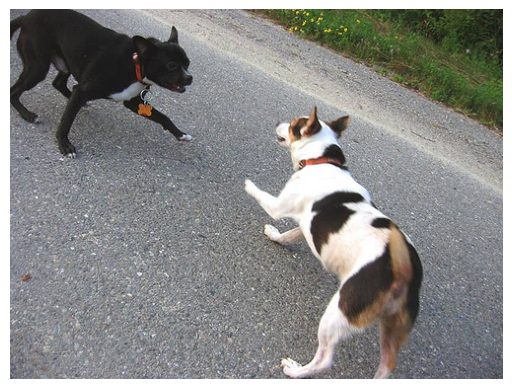

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing with each other on the sidewalk endseq


In [57]:
generate_caption("1001773457_577c3a7d70.jpg")

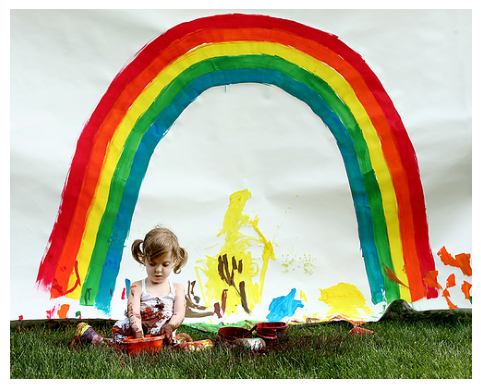

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl in pink dress is fingerpaints in front of rainbow rainbow endseq


In [58]:
generate_caption("1002674143_1b742ab4b8.jpg")

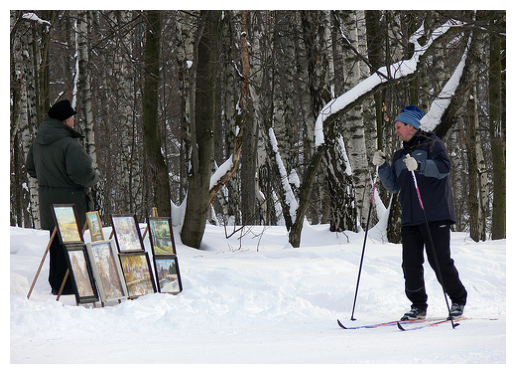

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq skier wearing red coat is skiing down snowy hill endseq


In [59]:
generate_caption("101669240_b2d3e7f17b.jpg")

## TESTING 

In [65]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

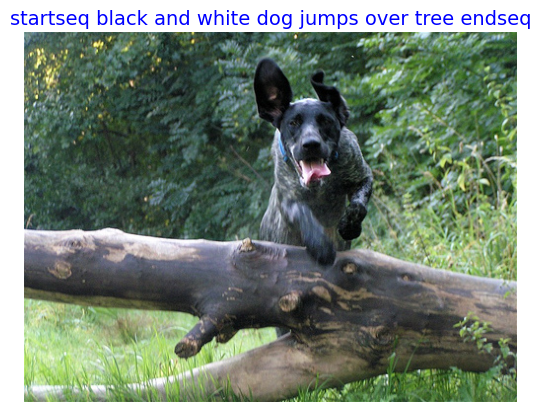

Generated Caption: startseq black and white dog jumps over tree endseq


In [67]:
# Set paths and load models
image_path = 'Flickr8K/Flicker8k_Images/1015584366_dfcec3c85a.jpg'
vgg_model = VGG16(weights='imagenet')
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)  # Use the second-to-last layer

# Load and preprocess image
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)  # Reshape to (1, 224, 224, 3)
image_array = preprocess_input(image_array)

# Extract features using VGG16
feature = vgg_model.predict(image_array, verbose=0)
feature = feature.reshape((1, 4096))

# Generate caption
predicted_caption = predict_caption(model, feature, tokenizer, max_length)

# Display the image and print the caption
plt.imshow(load_img(image_path))
plt.axis('off')  # Hide axes
plt.title(predicted_caption, fontsize=14, color='blue')
plt.show()

# Print caption in console as well
print('Generated Caption:', predicted_caption)

## HYPERPARAMETER TUNING 

In [72]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

# Assuming `mapping` is a dictionary with image IDs as keys and a list of captions as values
# Example structure: mapping = {'image_id_1': ['caption 1', 'caption 2'], 'image_id_2': ['caption A', 'caption B']}

# Combine all captions into a list for tokenizer training
all_captions = []
for captions in mapping.values():
    all_captions.extend(captions)

# Initialize and fit the tokenizer on the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Save the tokenizer for later use
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Tokenizer created and saved as 'tokenizer.pkl'")

Tokenizer created and saved as 'tokenizer.pkl'


In [82]:
import pickle

# Example: Build the caption mapping
# This assumes you have a file 'captions.txt' where each line is formatted as:
# <image_id> <caption>
# For instance: "1000268201_693b08cb0e dog running through the grass."

# Initialize the mapping dictionary
mapping = {}

# Read the captions file and build the mapping
with open('Flickr8K/captions.txt', 'r') as file:
    for line in file:
        tokens = line.strip().split()
        image_id, caption = tokens[0], " ".join(tokens[1:])
        if image_id not in mapping:
            mapping[image_id] = []
        mapping[image_id].append(caption)

# Save the mapping to a file for later use
with open('caption_mapping.pkl', 'wb') as f:
    pickle.dump(mapping, f)

print("Caption mapping created and saved as 'caption_mapping.pkl'")

Caption mapping created and saved as 'caption_mapping.pkl'


In [84]:
# Assuming you have lists of image IDs and captions pre-split for training and validation
# train_ids and val_ids should be predefined or loaded from a file

# Example setup (adjust paths and file reading logic as per your dataset structure)
import pickle

# Load image feature file created in the previous steps (e.g., 'image_features.pkl')
with open('image_features.pkl', 'rb') as f:
    features = pickle.load(f)

# Load caption mapping (a dictionary where keys are image IDs and values are lists of captions)
with open('caption_mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)

# Create lists of training and validation IDs
# (This example assumes you have pre-defined lists of train and val IDs)
train_ids = list(features.keys())[:int(0.8 * len(features))]  # Use 80% of data for training
val_ids = list(features.keys())[int(0.8 * len(features)):]   # Use remaining 20% for validation

# Ensure tokenizer is defined as it is required in the data generator
# Load tokenizer if saved earlier or create and fit one on your text data
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Specify max_length (max caption length) used for training
max_length = 35  # Example value, adjust to your dataset

# Now you can proceed with the training code as defined above

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model

# Ensure vocab_size is consistent with the tokenizer's actual vocabulary size
vocab_size = len(tokenizer.word_index) + 1

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size=32):
    """Generates data for Keras model training with validation for index bounds."""
    while True:
        X1, X2, y = [], [], []
        for key in data_keys:
            # Check if the key exists in the mapping and features
            if key in features and key in mapping:
                feature = features[key][0]
                for caption in mapping[key]:
                    seq = tokenizer.texts_to_sequences([caption])[0]
                    for i in range(1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]
                        
                        # Check if out_seq is within vocab_size bounds
                        if out_seq >= vocab_size:
                            print(f"Warning: Index {out_seq} out of bounds for vocab_size {vocab_size}")
                            continue

                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        
                        X1.append(feature)
                        X2.append(in_seq)
                        y.append(out_seq)
                        
                        if len(X1) >= batch_size:
                            yield (np.array(X1), np.array(X2)), np.array(y)
                            X1, X2, y = [], [], []  # Reset for next batch
            else:
                print(f"Warning: Image ID {key} not found in features or mapping.")

# Updated build_model function
def build_model(vocab_size, max_length, embedding_dim=256, lstm_units=256):
    # Image feature extractor part
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(lstm_units, activation='relu')(fe1)  # Adjust Dense units to match LSTM output

    # Sequence processing part
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(lstm_units)(se2)  # Ensure LSTM units match Dense layer in the image extractor

    # Decoder part
    decoder1 = add([fe2, se3])  # Now fe2 and se3 have matching shapes
    decoder2 = Dense(lstm_units, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

# Define output signature for tf.data.Dataset
output_signature = (
    (
        tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),  # X1: Image features
        tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)  # X2: Input sequence
    ),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)  # y: One-hot encoded output
)

# Create datasets from the generator with explicit output signature
batch_size = 32
train_steps = len(train_ids) // batch_size
val_steps = len(val_ids) // batch_size

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    output_signature=output_signature
).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    output_signature=output_signature
).prefetch(tf.data.experimental.AUTOTUNE)

# Hyperparameter tuning
embedding_dims = [256, 512]
lstm_units = [256, 512]
dropout_rates = [0.4, 0.5]
best_val_loss = float('inf')

for emb_dim in embedding_dims:
    for lstm_unit in lstm_units:
        for dropout_rate in dropout_rates:
            print(f"Training model with {emb_dim} embedding_dim, {lstm_unit} LSTM units, and {dropout_rate} dropout rate")

            # Build model with current hyperparameters
            model = build_model(vocab_size, max_length, embedding_dim=emb_dim, lstm_units=lstm_unit)

            # Set callbacks
            checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

            # Fit the model
            model.fit(
                train_dataset,
                validation_data=val_dataset,
                steps_per_epoch=train_steps,
                validation_steps=val_steps,
                epochs=25,
                callbacks=[checkpoint, early_stopping]
            )

            # Load and evaluate the best model
            model.load_weights('best_model.keras')
            val_loss = model.evaluate(val_dataset, steps=val_steps)
            
            # Save the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                model.save('best_image_captioning_model.h5')
                print(f"New best model saved with validation loss {val_loss}")

print("Hyperparameter tuning complete.")

Training model with 256 embedding_dim, 256 LSTM units, and 0.4 dropout rate
Epoch 1/25


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
# Save the model with the '.keras' extension directly
model.save('best_image_captioning_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Load the model saved in '.keras' format
model = load_model('best_image_captioning_model.keras')

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

# Assuming `captions` is a list of all caption texts used during training
captions = []  # Replace with the list of all captions

# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

# Save the tokenizer for future use
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import pickle

# Load the saved model in .keras format
model = load_model('best_image_captioning_model.keras')

# Load tokenizer (ensure it matches the training tokenizer)
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Vocabulary size and max_length used during training
vocab_size = len(tokenizer.word_index) + 1
max_length = 35  # Ensure this matches the max_length used during training

# Function to preprocess new images and extract features
def extract_image_features(image_path, model_feature_extractor):
    """Preprocess the image and extract features using a pretrained model."""
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.vgg16.preprocess_input(image)
    features = model_feature_extractor.predict(image, verbose=0)
    return features.reshape((1, 4096))

# Function to generate captions for an image
def generate_caption(model, tokenizer, photo_features, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo_features, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat, None)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text.replace('startseq ', '').replace(' endseq', '')

# Load a pre-trained model for feature extraction (e.g., VGG16)
feature_extractor = tf.keras.applications.VGG16(include_top=True)
feature_extractor = tf.keras.Model(inputs=feature_extractor.inputs, outputs=feature_extractor.layers[-2].output)

# Test on a new image
image_path = 'Flickr8K/Flicker8k_Images/1015584366_dfcec3c85a.jpg'  # Replace with the actual image path
features = extract_image_features(image_path, feature_extractor)
caption = generate_caption(model, tokenizer, features, max_length)

print("Generated Caption:", caption)